In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("distilled_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model
from knowledge_distillation import KnowledgeDistillation

In [2]:
conf = {
    "batch_size": 512,
    "epochs": 10,
    "learning_rate": 0.0001
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("distilled_models", ""), "datasets", "network_packet_data_test.csv")

data, labels, label_dict = parse_dataset(network_data_file)

X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
X_train, X_val, X_test = X_train.unsqueeze(-1), X_val.unsqueeze(-1), X_test.unsqueeze(-1)
print(X_train.shape)
print(y_train.shape)

# create train, val and test datasets
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513, 1])
torch.Size([356334])


In [7]:
# create LSTM model:
class INML(nn.Module):
    def __init__(self, i_size, h_size):
        super(INML, self).__init__()
        self.i_size = i_size
        self.h_size = h_size
        self.lstm1 = nn.LSTM(input_size=i_size, hidden_size=h_size, num_layers=4, batch_first=True, dropout=0.15, bidirectional=True, device=device)
        self.bn1 = nn.BatchNorm1d(2 * h_size)

        self.fc = nn.Sequential(
            nn.Linear(2*h_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(128, 24)
        )
        
    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(8, x.shape[0], self.h_size).to(device)
            c0 = torch.zeros(8, x.shape[0], self.h_size).to(device)

        output, (h0, c0) = self.lstm1(x, (h0, c0))  # output: [B, T, 2*h_size]

        # take last layer's hidden state (both directions)
        # h0 shape: [num_layers*2, B, size]
        h_last = h0.view(4, 2, x.shape[0], self.h_size)[-1]  # [2, B, h_size]
        h_last = torch.cat((h_last[0], h_last[1]), dim=1)  # [B, 2*h_size]

        # apply BN + FC
        h_last = self.bn1(h_last)         # [B, 2*h_size] → batch norm


        out = self.fc(h_last)            # [B, 24]
        return out

In [12]:
class LightLSTM(nn.Module):
    def __init__(self, i_size, h_size):
        super(LightLSTM, self).__init__()
        self.i_size = i_size
        self.h_size = h_size
        self.lstm1 = nn.LSTM(input_size=i_size, hidden_size=h_size, num_layers=1, batch_first=True, bidirectional=True, device=device)
        self.bn1 = nn.BatchNorm1d(2 * h_size)

        self.fc = nn.Sequential(
            nn.Linear(2*h_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(32, 24)
        )

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(2, x.shape[0], self.h_size).to(device)
            c0 = torch.zeros(2, x.shape[0], self.h_size).to(device)

        output, (h0, c0) = self.lstm1(x, (h0, c0))  # output: [B, T, 2*h_size]

        # take last layer's hidden state (both directions)
        # h0 shape: [num_layers*2, B, size]
        h_last = h0.view(1, 2, x.shape[0], self.h_size)[-1]  # [2, B, h_size]
        h_last = torch.cat((h_last[0], h_last[1]), dim=1)  # [B, 2*h_size]

        # apply BN + FC
        h_last = self.bn1(h_last)         # [B, 2*h_size] → batch norm


        out = self.fc(h_last)            # [B, 24]
        return out

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.1, alpha=0.9, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [10]:
teacher_model = INML(X_train.shape[2], 64).to(device)
teacher_criterion = FocalLoss()
teacher_optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
teacher_scheduler = torch.optim.lr_scheduler.ExponentialLR(teacher_optimizer, 0.9)

teacher = Model(teacher_model, teacher_criterion, teacher_optimizer, teacher_scheduler, device)

checkpoint_path = os.path.join(os.getcwd().replace("distilled_models", ""), "checkpoint", "lstm_model.pth")
teacher.load(checkpoint_path)

Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/lstm_model.pth!


In [13]:
# create light model
torch.manual_seed(42)
student_model = LightLSTM(X_train.shape[2], 32).to(device)
student_criterion = FocalLoss()
student_optimizer = torch.optim.AdamW(student_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
student_scheduler = torch.optim.lr_scheduler.ExponentialLR(student_optimizer, 0.9)

student = Model(student_model, student_criterion, student_optimizer, student_scheduler, device)

In [14]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/10, Accuracy: 72.98%, Train loss: 1.4734, Val loss: 0.8433
Epoch: 2/10, Accuracy: 80.08%, Train loss: 0.6660, Val loss: 0.4781
Epoch: 3/10, Accuracy: 82.28%, Train loss: 0.4474, Val loss: 0.3456
Epoch: 4/10, Accuracy: 84.38%, Train loss: 0.3528, Val loss: 0.2800
Epoch: 5/10, Accuracy: 85.93%, Train loss: 0.2976, Val loss: 0.2369
Epoch: 6/10, Accuracy: 87.04%, Train loss: 0.2614, Val loss: 0.2087
Epoch: 7/10, Accuracy: 87.54%, Train loss: 0.2354, Val loss: 0.1909
Epoch: 8/10, Accuracy: 88.25%, Train loss: 0.2161, Val loss: 0.1737
Epoch: 9/10, Accuracy: 88.77%, Train loss: 0.2010, Val loss: 0.1626
Epoch: 10/10, Accuracy: 89.39%, Train loss: 0.1889, Val loss: 0.1521


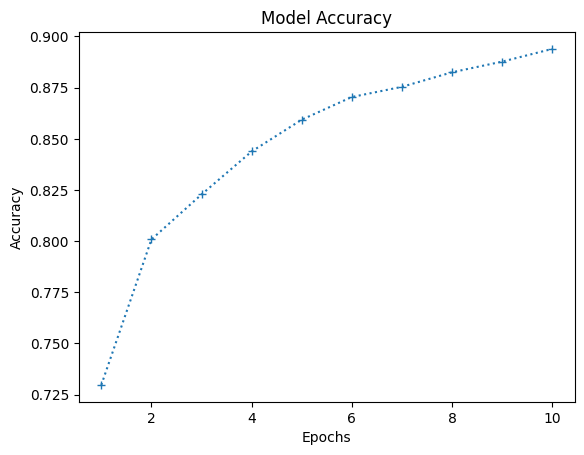

In [15]:
accuracy, train_loss, val_loss = student.train(train_loader=train_loader, val_loader=val_loader, epochs=conf["epochs"])
plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [16]:
test_loss, test_acc = student.evaluate(test_loader)
print(f"Accuracy: {100*test_acc:.2f}%, Test loss: {test_loss:.4f}")

Accuracy: 89.32%, Test loss: 0.1537


In [17]:
# create new light model
torch.manual_seed(42)
new_student_model = LightLSTM(X_train.shape[2], 32).to(device)
new_student_criterion = FocalLoss()
new_student_optimizer = torch.optim.AdamW(new_student_model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
new_student_scheduler = torch.optim.lr_scheduler.ExponentialLR(new_student_optimizer, 0.9)

new_student = Model(new_student_model, new_student_criterion, new_student_optimizer, new_student_scheduler, device)

In [18]:
kd = KnowledgeDistillation(teacher=teacher, student=new_student, device=device)

Epoch: 1/10, Accuracy: 72.02%, Train loss: 0.0024, Val loss: 0.8390
Epoch: 2/10, Accuracy: 79.80%, Train loss: 0.0011, Val loss: 0.4809
Epoch: 3/10, Accuracy: 82.55%, Train loss: 0.0008, Val loss: 0.3513
Epoch: 4/10, Accuracy: 84.17%, Train loss: 0.0006, Val loss: 0.2835
Epoch: 5/10, Accuracy: 86.54%, Train loss: 0.0005, Val loss: 0.2392
Epoch: 6/10, Accuracy: 87.86%, Train loss: 0.0005, Val loss: 0.2044
Epoch: 7/10, Accuracy: 89.12%, Train loss: 0.0004, Val loss: 0.1837
Epoch: 8/10, Accuracy: 89.72%, Train loss: 0.0004, Val loss: 0.1687
Epoch: 9/10, Accuracy: 90.51%, Train loss: 0.0004, Val loss: 0.1531
Epoch: 10/10, Accuracy: 91.12%, Train loss: 0.0003, Val loss: 0.1446


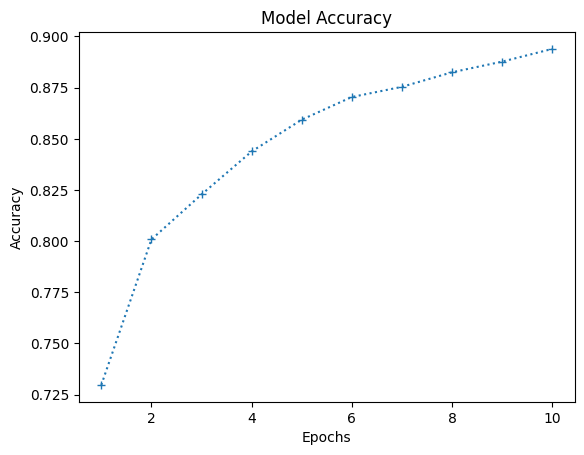

In [ ]:
new_accuracy, new_train_loss, new_val_loss = kd.train_kd(train_loader, val_loader, conf["epochs"])
plot_data(new_accuracy, type="Accuracy", title="Model Accuracy")

In [20]:
new_test_loss, new_test_acc = new_student.evaluate(test_loader)
print(f"Accuracy: {100*new_test_acc:.2f}%, Test loss: {new_test_loss:.4f}")

Accuracy: 91.05%, Test loss: 0.1460


In [21]:
new_checkpoint_path = os.path.join(os.getcwd().replace("distilled_models", ""), "checkpoint", "light_lstm_model.pth")
new_student.save(new_checkpoint_path)

Checkpoint saved at /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_lstm_model.pth
